# Network Traffic Forecasting (using time series data)

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demonstrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to do **multivariate multistep forecasting** using Project Chronos.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [39]:
def get_drop_dates_and_len(df, target_col="total", allow_missing_num=3):
    """
    Find missing values and get records to drop
    """
    missing_num = df[target_col].isnull().astype(int).groupby(df[target_col].notnull().astype(int).cumsum()).sum()
    missing_num = missing_num[missing_num > 0]
    drop_datetimes = df.iloc[(missing_num.index + missing_num.cumsum() - missing_num).values].index
    drop_datetimes = drop_datetimes[missing_num > allow_missing_num]
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_len = drop_missing_num.values
    return drop_datetimes, drop_len

In [40]:
def rm_missing_weeks(start_dts, missing_lens, df):
    """
    Drop weeks that contains more than 3 consecutive missing values.
    If consecutive missing values across weeks, we remove all the weeks.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [41]:
def gen_dataset_matrix(dataset, look_back, horizon, target_col_indexes):
    """
    Generate input samples from rolling
    """
    X, Y = [], []
    if len(target_col_indexes) == 1:
        del_col_index = {0, 1}.difference(set(target_col_indexes)).pop()
        data = np.delete(dataset, del_col_index, axis=1)
    else:
        data = dataset
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i: (i + look_back)])
        Y.append(data[(i + look_back): (i + look_back + horizon), target_col_indexes])
    return np.array(X), np.array(Y)

In [42]:
def unscale(scaler, y, target_col_indexes):
    """
    data needs to be normalized (scaled) before feeding into models. 
    This is to inverse the effect of normlization to get reasonable forecast results.
    """
    dummy_feature_shape = scaler.scale_.shape[0]
    y_dummy = np.zeros(((y.shape[0], y.shape[1], dummy_feature_shape)))
    y_dummy[:, :, target_col_indexes] = y
    y_unscale = scaler.inverse_transform(y_dummy)[:, :, target_col_indexes]
    return y_unscale

In [43]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(12,5))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below. 

* First, run the script `get_data.sh` to download the raw data. It will download the monthly aggregated traffic data in year 2018 and 2019 into `data` folder. The raw data contains aggregated network traffic (average MBPs and total bytes) as well as other metrics. 

* Second, run `extract_data.sh` to extract relavant traffic KPI's from raw data, i.e. `AvgRate` for average use rate, and `total` for total bytes. The script will extract the KPI's with timestamps into `data/data.csv`.

* Finally, use pandas to load `data/data.csv` into a dataframe as shown below

In [44]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
raw_df = pd.read_csv("data/data.csv")

Below are some example records of the data

In [46]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the network traffic data we're using, the processing contains 3 parts:
1. Convert string datetime to TimeStamp
2. Unify the measurement scale for `AvgRate` value - some uses Mbps, some uses Gbps 
3. Handle missing data (fill or drop).

In [47]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

In [48]:
# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps' 
raw_df.AvgRate.str[-4:].unique()

array(['Mbps', 'Gbps'], dtype=object)

In [49]:
# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x:float(x[:-4]) if x.endswith("Mbps") else float(x[:-4])*1000)

In [50]:
df["total"] = raw_df["total"]
df.set_index("StartTime", inplace=True)

In [51]:
df.head()

,AvgRate,total
StartTime,,
2018-01-01 00:00:00,306.23,275605455598
2018-01-01 02:00:00,285.03,256527692256
2018-01-01 04:00:00,247.39,222652190823
2018-01-01 06:00:00,211.55,190396029658
2018-01-01 08:00:00,234.82,211340468977


In [52]:
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
df = df.reindex(full_idx)
print("no. of n/a values:")
print(df.isna().sum())

no. of n/a values:
AvgRate    3
total      3
dtype: int64


Here, we drop weeks with more than 3 consecutive missing values and fill other missing values remained.

In [53]:
drop_dts, drop_len = get_drop_dates_and_len(df)
df = rm_missing_weeks(drop_dts, drop_len, df)

In [54]:
df.ffill(inplace=True)

Plot the data to see how the KPI's look like

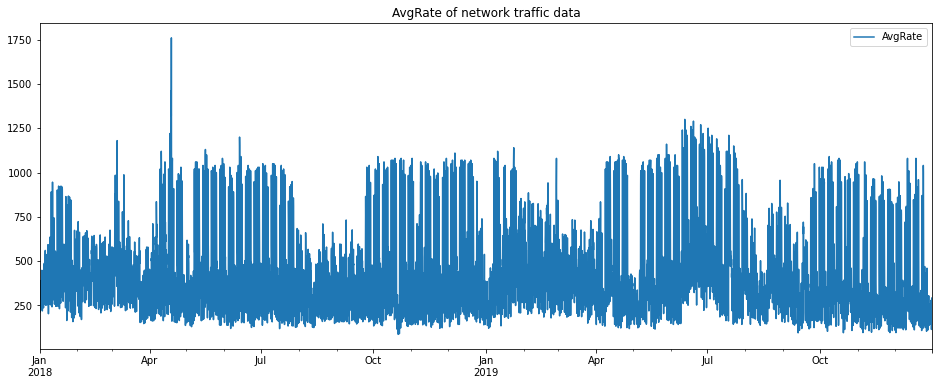

In [55]:
ax = df.plot(y='AvgRate', figsize=(16,6), title="AvgRate of network traffic data")

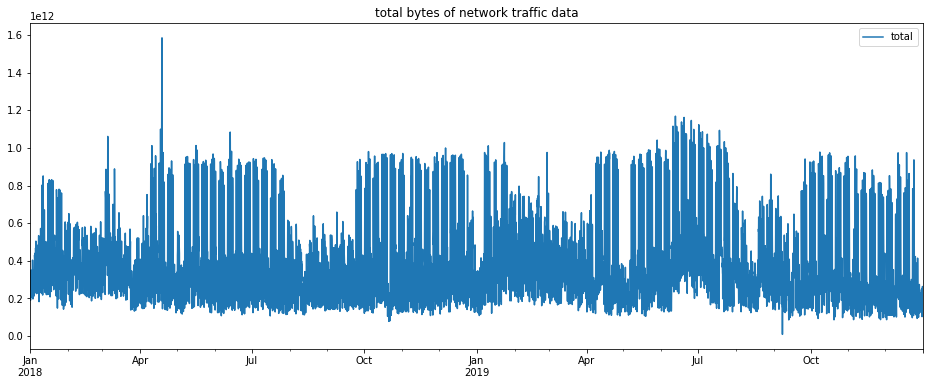

In [56]:
ax = df.plot(y='total', figsize=(16,6), title='total bytes of network traffic data')

## Feature Engineering

For feature engineering, we use year, month, week, day of week and hour as features in addition to the target KPI values.

In [57]:
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.week
df["dayofweek"] = df.index.dayofweek
df["hour"] = df.index.hour

/home/junweid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
df.head()

,AvgRate,total,year,month,week,dayofweek,hour
2018-01-01 00:00:00,306.23,2.756055e+11,2018,1,1,0,0
2018-01-01 02:00:00,285.03,2.565277e+11,2018,1,1,0,2
2018-01-01 04:00:00,247.39,2.226522e+11,2018,1,1,0,4
2018-01-01 06:00:00,211.55,1.903960e+11,2018,1,1,0,6
2018-01-01 08:00:00,234.82,2.113405e+11,2018,1,1,0,8


## Data preparation

Now we split the dataset into train and test.

In [59]:
test_num = 1000
# we look back one week data which is of the frequency of 2h.
look_back = 84
# specify the number of steps to be predicted，one day is selected by default.
horizon = 12

test_split_index = test_num + look_back

train_df = df[:-test_num]
test_df = df[-test_split_index:]
test_df = test_df.reset_index(drop=True)

Then standardize train, test data and featues.

In [60]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_df)
scaled_test = standard_scaler.transform(test_df)

Last, we generate model input samples by sliding window along time axis.

In [61]:
multi_target_col_indexes = [0, 1]
multi_target_value = ["AvgRate","total"]

x_train, y_train = gen_dataset_matrix(scaled_train, look_back, horizon, multi_target_col_indexes)
x_test, y_test = gen_dataset_matrix(scaled_test, look_back, horizon, multi_target_col_indexes)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7665, 84, 7), (7665, 12, 2), (989, 84, 7), (989, 12, 2))

# Time series forecasting 

We demonstrate how to use chronos TCNForecaster for multi-variate and multi-step forecasting. For more details, you can refer to TCNForecaster document [here](https://analytics-zoo.github.io/master/#Chronos/API/TCNForecaster/).
First, we initialize a forecaster.
* `num_channels`: The filter numbers of the convolutional layers. It can be a list.
* `kernel_size`: Convolutional layer filter height.

In [62]:
from zoo.chronos.model.forecast.tcn_forecaster import TCNForecaster
forecaster = TCNForecaster(past_seq_len = look_back,
                           future_seq_len = horizon,
                           input_feature_num = x_train.shape[-1],
                           output_feature_num = 2, # "AvgRate" and "total"
                           num_channels = [30] * 7, 
                           kernel_size = 4, 
                           dropout = 0.1, 
                           lr = 0.001)

You can use this method to print the parameter list.

In [63]:
forecaster.data_config, forecaster.config

({'past_seq_len': 84,
  'future_seq_len': 12,
  'input_feature_num': 7,
  'output_feature_num': 2},
 {'lr': 0.001,
  'loss': 'mse',
  'num_channels': [30, 30, 30, 30, 30, 30, 30],
  'kernel_size': 4,
  'optim': 'Adam',
  'dropout': 0.1})

In [64]:
%%time
forecaster.fit(x=x_train, y=y_train, epochs=20, batch_size=256, metric="mse")

Loss: 0.11880531162023544: 100%|██████████| 30/30 [00:02<00:00, 14.99it/s]
CPU times: user 6min 38s, sys: 1.66 s, total: 6min 40s
Wall time: 40.1 s


0.11233555352034082

After training is finished. You can use the forecaster to do prediction and evaluation.

In [65]:
# make prediction
y_pred = forecaster.predict(x_test)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too. 

In [66]:
y_pred_unscale = unscale(standard_scaler, y_pred, multi_target_col_indexes)
y_test_unscale = unscale(standard_scaler, y_test, multi_target_col_indexes)

Calculate mean square error and the symetric mean absolute percentage error.

In [67]:
# evaluate with mse, smape
from zoo.automl.common.metrics import Evaluator
avgrate_mse = Evaluator.evaluate("mse", y_test_unscale[:, :, 0], y_pred_unscale[:, :, 0], multioutput='uniform_average')
avgrate_smape = Evaluator.evaluate("smape", y_test_unscale[:, :, 0], y_pred_unscale[:, :, 0], multioutput='uniform_average')
total_mse = Evaluator.evaluate("mse", y_test_unscale[:, :, 1], y_pred_unscale[:, :, 1], multioutput='uniform_average')
total_smape = Evaluator.evaluate("smape", y_test_unscale[:, :, 1], y_pred_unscale[:, :, 1], multioutput='uniform_average')
print(f"Evaluation result for AvgRate: mean squared error is {'%.2f' % avgrate_mse}, sMAPE is {'%.2f' % avgrate_smape}")
print(f"Evaluation result for total: mean squared error is {'%.2f' % total_mse}, sMAPE is {'%.2f' % total_smape}")

Evaluation result for AvgRate: mean squared error is 10345.06, sMAPE is 9.50
Evaluation result for total: mean squared error is 8375132697274323304448.00, sMAPE is 9.34


## Visualization

Plot actual and prediction values for `AvgRate` KPI

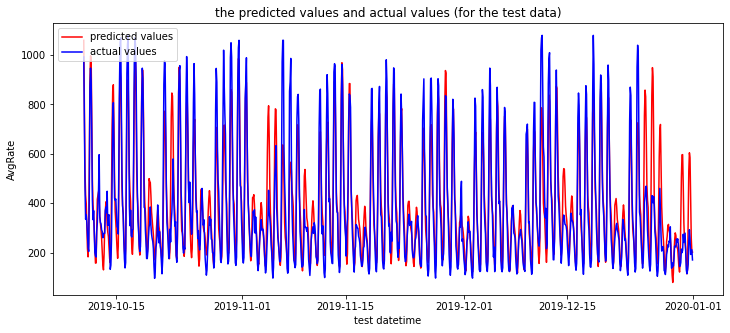

In [68]:
test_date=df[-y_pred_unscale.shape[0]:].index
# You can choose the number of painting steps by specifying the step by yourself.
step = -1 # the last step
target_name = "AvgRate"
target_index = 0
plot_predict_actual_values(date=test_date, y_pred=y_pred_unscale[:, step, target_index], y_test=y_test_unscale[:, step, target_index], ylabel=target_name)

Plot actual and prediction values for `total bytes` KPI

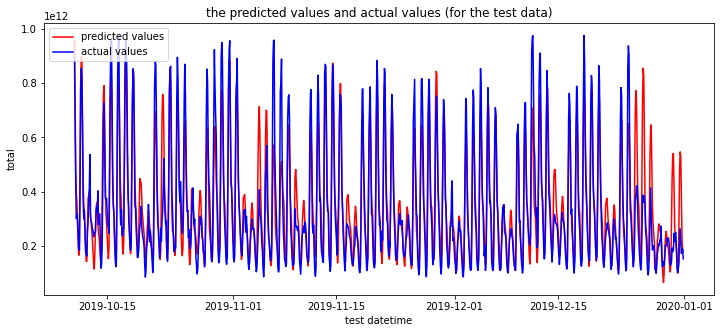

In [69]:
target_name = "total"
target_index = 1
plot_predict_actual_values(date=test_date, y_pred=y_pred_unscale[:, step, target_index], y_test=y_test_unscale[:, step, target_index], ylabel=target_name)